In [36]:
from numpy import*
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
%matplotlib inline

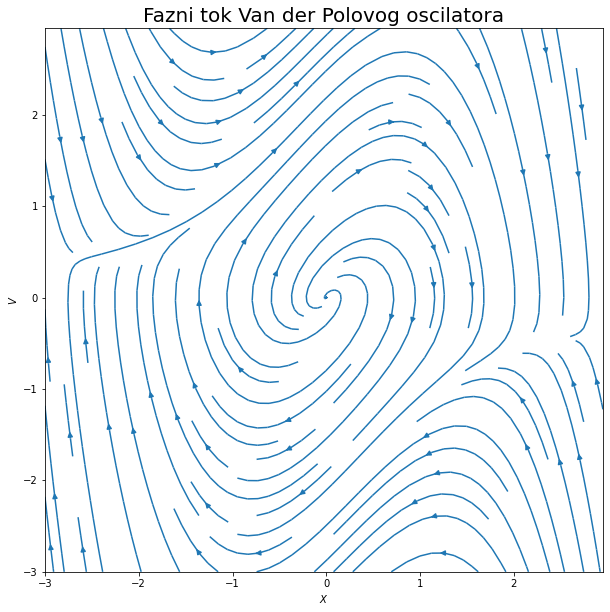

In [84]:
#Korisne funkcije
def van_der_pol(state,t,mu = 1):
    """Generira diferencijalnu jednadžbu"""
    x = state[0]
    dx = state[1]
    d2x = -x  + mu*( 1 - x**2 )*dx
    
    return array([dx,d2x])
dt = 0.01   

def vector_field(x,dx,dt = dt,mu = 1):
    
    ux = dx
    uy = -x + mu*(1 - x**2)*dx
    return ux,uy


x_mesh = arange(-3,3,5e-2)
y_mesh = arange(-3,3,5e-2)
Npts = len(x_mesh)
u = zeros([Npts,Npts])
v = zeros([Npts,Npts])

for i in range(Npts):
    for j in range(Npts):
        u[j,i],v[j,i] = vector_field(x_mesh[i],y_mesh[j])

        
X,Y = meshgrid(x_mesh,y_mesh) 
frame,fig =plt.subplots(figsize = (10,10))
fig.streamplot(x_mesh,y_mesh,u,v)
# q = fig.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5],units = "width",color = "blue",label ="fazni tok")
# qk = fig.quiverkey(q, 0.9, 0.9, 2,label = "")
#fig.legend()
fig.set_title("Fazni tok Van der Polovog oscilatora",fontsize = 20)
fig.set_xlabel(r"$X$")
fig.set_ylabel(r"$V$")
print()

In [38]:
#Definiranje modela
#Najbolja arhietktura 2x8x8x2
model= keras.Sequential([layers.BatchNormalization(input_shape = [2]),
                        layers.Dense(8,activation = "swish"),
                        layers.BatchNormalization(),
                        #layers.Dropout(rate = 0.1),
                        
#                         layers.Dense(5,activation = "swish"),
#                         layers.BatchNormalization(),
#                         #layers.Dropout(rate =0.05 ),
                          
#                         layers.Dense(8,activation = "swish"),
#                         layers.BatchNormalization(),
#                          layers.Dropout(rate = 0.1),
                         
#                         layers.Dense(8,activation = "swish"),
#                         layers.BatchNormalization(),
#                         layers.Dropout(rate = 0.1),
                         
#                         layers.Dense(8,activation = "swish"),
#                         layers.BatchNormalization(),
#                         layers.Dropout(rate = 0.1),
                       
                        layers.Dense(8,activation = "swish"),
                        layers.BatchNormalization(),
                        #layers.Dropout(rate = 0.1),
                        layers.Dense(2)])

#Optimizaciski algoritam
opt =keras.optimizers.Adam(
    learning_rate=0.002)
#mse - Mean square error - to želiš minimizirati
model.compile(optimizer = opt,
               loss = 'mse')


In [268]:
#Generiranje podataka za učenje modela
#Za provjeru i za testiranje modela

Ntrain = 600 #Originalno 600
trainX =  random.uniform(-3,3,(Ntrain,2))
trainY = list()

Ntest = 300
testX =  random.uniform(-3,3,(Ntest,2))
testY = list()

Nvalid = 300
validX =  random.uniform(-3,3,(Nvalid,2))
validY = list()

for i in range(Ntrain):
    trainY.append(vector_field(trainX[i][0],trainX[i][1]))    
for i in range(Ntest):
    testY.append(vector_field(testX[i][0],testX[i][1]))
for i in range(Nvalid):
    validY.append(vector_field(validX[i][0],validX[i][1]))
trainY = array(trainY)
testY = array(testY)
validY = array(validY)

In [269]:
#Treniranje modela
history = model.fit(trainX,trainY,
                   validation_data=(validX,validY),
                    batch_size = 64,
                    epochs = 500
                   )

Epoch 1/500
10/10 [==============================] - 0s 8ms/step - loss: 7.2597 - val_loss: 6.7813
Epoch 2/500
10/10 [==============================] - 0s 5ms/step - loss: 4.5419 - val_loss: 4.9525
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 2.3658 - val_loss: 3.2618
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 1.5377 - val_loss: 1.3390
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 1.6193 - val_loss: 1.3651
Epoch 6/500
10/10 [==============================] - 0s 5ms/step - loss: 1.3889 - val_loss: 1.5571
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 1.5071 - val_loss: 1.5236
Epoch 8/500
10/10 [==============================] - 0s 5ms/step - loss: 1.0054 - val_loss: 1.5521
Epoch 9/500
10/10 [==============================] - 0s 7ms/step - loss: 1.7521 - val_loss: 1.9032
Epoch 10/500
10/10 [==============================] - 0s 6ms/step - loss: 1.3691 - val_loss: 1.5885
Epoch 11/

10/10 [==============================] - 0s 5ms/step - loss: 0.6661 - val_loss: 0.1014
Epoch 84/500
10/10 [==============================] - 0s 5ms/step - loss: 0.7207 - val_loss: 0.1065
Epoch 85/500
10/10 [==============================] - 0s 4ms/step - loss: 1.3727 - val_loss: 0.1350
Epoch 86/500
10/10 [==============================] - 0s 4ms/step - loss: 1.2171 - val_loss: 0.1668
Epoch 87/500
10/10 [==============================] - 0s 5ms/step - loss: 1.2135 - val_loss: 0.1374
Epoch 88/500
10/10 [==============================] - 0s 4ms/step - loss: 1.0270 - val_loss: 0.1002
Epoch 89/500
10/10 [==============================] - 0s 5ms/step - loss: 0.9835 - val_loss: 0.1264
Epoch 90/500
10/10 [==============================] - 0s 4ms/step - loss: 1.2531 - val_loss: 0.1269
Epoch 91/500
10/10 [==============================] - 0s 4ms/step - loss: 0.9300 - val_loss: 0.1590
Epoch 92/500
10/10 [==============================] - 0s 4ms/step - loss: 1.1895 - val_loss: 0.1278
Epoch 93/500


10/10 [==============================] - 0s 5ms/step - loss: 0.9516 - val_loss: 0.0596
Epoch 165/500
10/10 [==============================] - 0s 5ms/step - loss: 0.9658 - val_loss: 0.0604
Epoch 166/500
10/10 [==============================] - 0s 4ms/step - loss: 1.0681 - val_loss: 0.0620
Epoch 167/500
10/10 [==============================] - 0s 5ms/step - loss: 1.1499 - val_loss: 0.0456
Epoch 168/500
10/10 [==============================] - 0s 4ms/step - loss: 1.1137 - val_loss: 0.0805
Epoch 169/500
10/10 [==============================] - 0s 5ms/step - loss: 1.4178 - val_loss: 0.0643
Epoch 170/500
10/10 [==============================] - 0s 5ms/step - loss: 1.3924 - val_loss: 0.0689
Epoch 171/500
10/10 [==============================] - 0s 4ms/step - loss: 1.3629 - val_loss: 0.1048
Epoch 172/500
10/10 [==============================] - 0s 4ms/step - loss: 0.9093 - val_loss: 0.1341
Epoch 173/500
10/10 [==============================] - 0s 4ms/step - loss: 0.8619 - val_loss: 0.0840
Epoc

10/10 [==============================] - 0s 4ms/step - loss: 1.1733 - val_loss: 0.0568
Epoch 246/500
10/10 [==============================] - 0s 4ms/step - loss: 1.0749 - val_loss: 0.0674
Epoch 247/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6474 - val_loss: 0.0695
Epoch 248/500
10/10 [==============================] - 0s 4ms/step - loss: 1.2588 - val_loss: 0.0493
Epoch 249/500
10/10 [==============================] - 0s 4ms/step - loss: 0.7761 - val_loss: 0.1010
Epoch 250/500
10/10 [==============================] - 0s 4ms/step - loss: 1.3016 - val_loss: 0.0927
Epoch 251/500
10/10 [==============================] - 0s 4ms/step - loss: 0.5183 - val_loss: 0.1260
Epoch 252/500
10/10 [==============================] - 0s 4ms/step - loss: 0.7386 - val_loss: 0.0661
Epoch 253/500
10/10 [==============================] - 0s 4ms/step - loss: 1.3420 - val_loss: 0.0560
Epoch 254/500
10/10 [==============================] - 0s 4ms/step - loss: 0.7285 - val_loss: 0.0409
Epoc

10/10 [==============================] - 0s 4ms/step - loss: 1.0364 - val_loss: 0.0694
Epoch 327/500
10/10 [==============================] - 0s 5ms/step - loss: 0.8375 - val_loss: 0.0937
Epoch 328/500
10/10 [==============================] - 0s 4ms/step - loss: 0.8035 - val_loss: 0.0664
Epoch 329/500
10/10 [==============================] - 0s 4ms/step - loss: 0.7957 - val_loss: 0.1037
Epoch 330/500
10/10 [==============================] - 0s 4ms/step - loss: 0.9040 - val_loss: 0.0898
Epoch 331/500
10/10 [==============================] - 0s 4ms/step - loss: 1.3481 - val_loss: 0.0884
Epoch 332/500
10/10 [==============================] - 0s 4ms/step - loss: 0.7541 - val_loss: 0.0779
Epoch 333/500
10/10 [==============================] - 0s 4ms/step - loss: 1.2810 - val_loss: 0.0820
Epoch 334/500
10/10 [==============================] - 0s 4ms/step - loss: 0.9538 - val_loss: 0.0642
Epoch 335/500
10/10 [==============================] - 0s 4ms/step - loss: 1.1235 - val_loss: 0.0550
Epoc

10/10 [==============================] - 0s 4ms/step - loss: 1.0753 - val_loss: 0.0348
Epoch 408/500
10/10 [==============================] - 0s 5ms/step - loss: 1.2502 - val_loss: 0.1003
Epoch 409/500
10/10 [==============================] - 0s 4ms/step - loss: 0.7597 - val_loss: 0.0781
Epoch 410/500
10/10 [==============================] - 0s 4ms/step - loss: 1.1801 - val_loss: 0.0329
Epoch 411/500
10/10 [==============================] - 0s 4ms/step - loss: 0.8001 - val_loss: 0.0367
Epoch 412/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6656 - val_loss: 0.0321
Epoch 413/500
10/10 [==============================] - 0s 4ms/step - loss: 1.0561 - val_loss: 0.0251
Epoch 414/500
10/10 [==============================] - 0s 4ms/step - loss: 1.2821 - val_loss: 0.0537
Epoch 415/500
10/10 [==============================] - 0s 4ms/step - loss: 1.0476 - val_loss: 0.0370
Epoch 416/500
10/10 [==============================] - 0s 4ms/step - loss: 0.8518 - val_loss: 0.0749
Epoc

10/10 [==============================] - 0s 4ms/step - loss: 1.0971 - val_loss: 0.0789
Epoch 489/500
10/10 [==============================] - 0s 4ms/step - loss: 0.8162 - val_loss: 0.0382
Epoch 490/500
10/10 [==============================] - 0s 4ms/step - loss: 1.1441 - val_loss: 0.0547
Epoch 491/500
10/10 [==============================] - 0s 4ms/step - loss: 1.2282 - val_loss: 0.0756
Epoch 492/500
10/10 [==============================] - 0s 5ms/step - loss: 0.7486 - val_loss: 0.0719
Epoch 493/500
10/10 [==============================] - 0s 4ms/step - loss: 0.9955 - val_loss: 0.0692
Epoch 494/500
10/10 [==============================] - 0s 4ms/step - loss: 1.1126 - val_loss: 0.0670
Epoch 495/500
10/10 [==============================] - 0s 4ms/step - loss: 0.9350 - val_loss: 0.0584
Epoch 496/500
10/10 [==============================] - 0s 4ms/step - loss: 1.4709 - val_loss: 0.0706
Epoch 497/500
10/10 [==============================] - 0s 4ms/step - loss: 0.8779 - val_loss: 0.0510
Epoc

10/10 [==============================] - 0s 774us/step - loss: 0.0930


0.0930255725979805

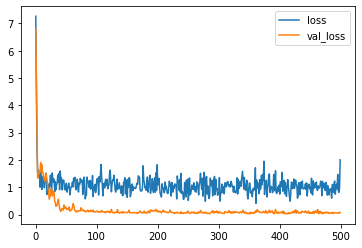

In [270]:
#Točnost modela
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
model.evaluate(testX,testY)

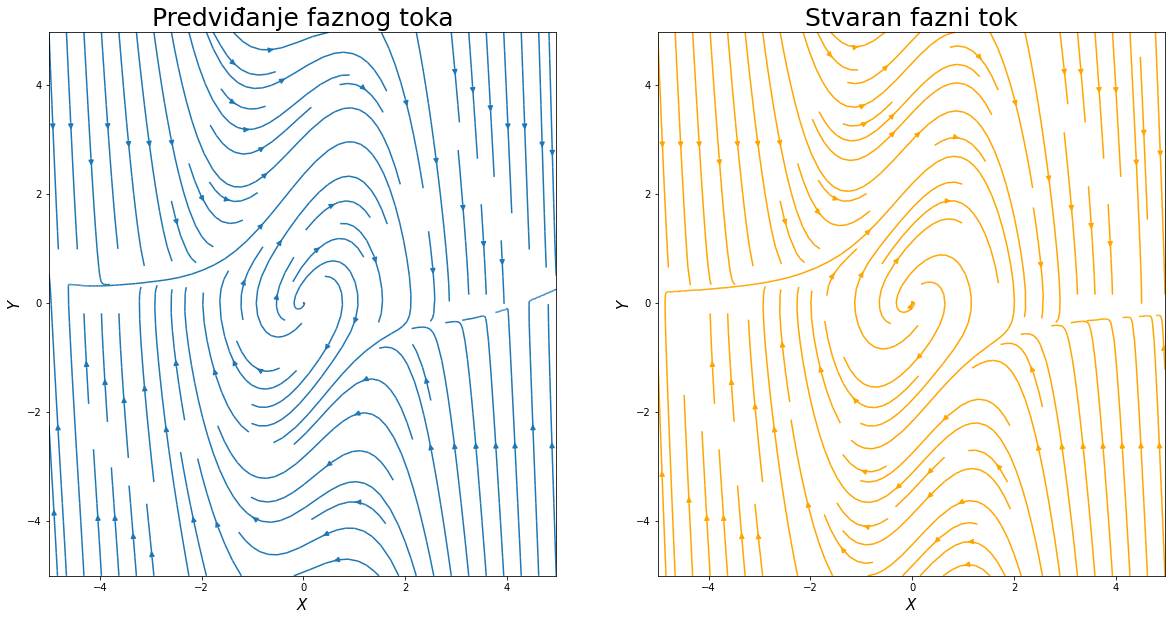

In [271]:
#Provjera kako model radi na nasumično odabranim točkama
#Cilj mu je pogoditi fazni tok u točku odnosno diferencijanu jednadžbu
x_mesh = arange(-5,5,10/300)
y_mesh = arange(-5,5,10/300)
u = zeros((len(x_mesh),len(x_mesh)))
v = zeros((len(x_mesh),len(x_mesh)))

data =[]
for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        data.append([x_mesh[j],y_mesh[i]])   
        
        
data = array(data)
pred = model.predict(data)
pred =pred.reshape(300,300,2)


for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        u[j,i],v[j,i] = vector_field(x_mesh[i],y_mesh[j])


frame,fig = plt.subplots(1,2,figsize = (20,10))
fig[0].streamplot(x_mesh,y_mesh,pred[:,:,0],pred[:,:,1],density = 1)
fig[1].streamplot(x_mesh,y_mesh,u,v,density = 1,color ="orange")
fig[0].set_title("Predviđanje faznog toka",fontsize = 25)
fig[1].set_title("Stvaran fazni tok",fontsize = 25)
fig[0].set_xlabel(r"$X$",fontsize = 15)
fig[0].set_ylabel(r"$Y$",fontsize = 15)
fig[1].set_xlabel(r"$X$",fontsize = 15)
fig[1].set_ylabel(r"$Y$",fontsize = 15)
print()
frame.savefig("Usporedba")


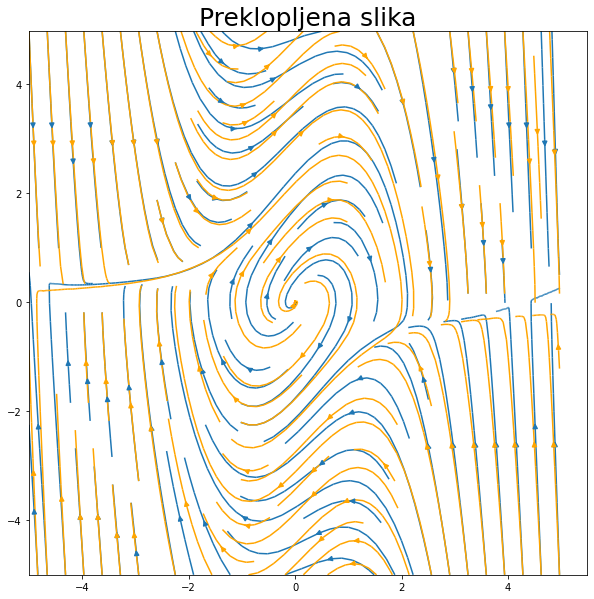

In [273]:
frame,fig = plt.subplots(figsize = (10,10))
dns = 1
fig.streamplot(x_mesh,y_mesh,pred[:,:,0],pred[:,:,1],density = dns)
fig.streamplot(x_mesh,y_mesh,u,v,density = dns,color ="orange")

fig.set_title("Preklopljena slika",fontsize = 25)
frame.savefig("Preklop")


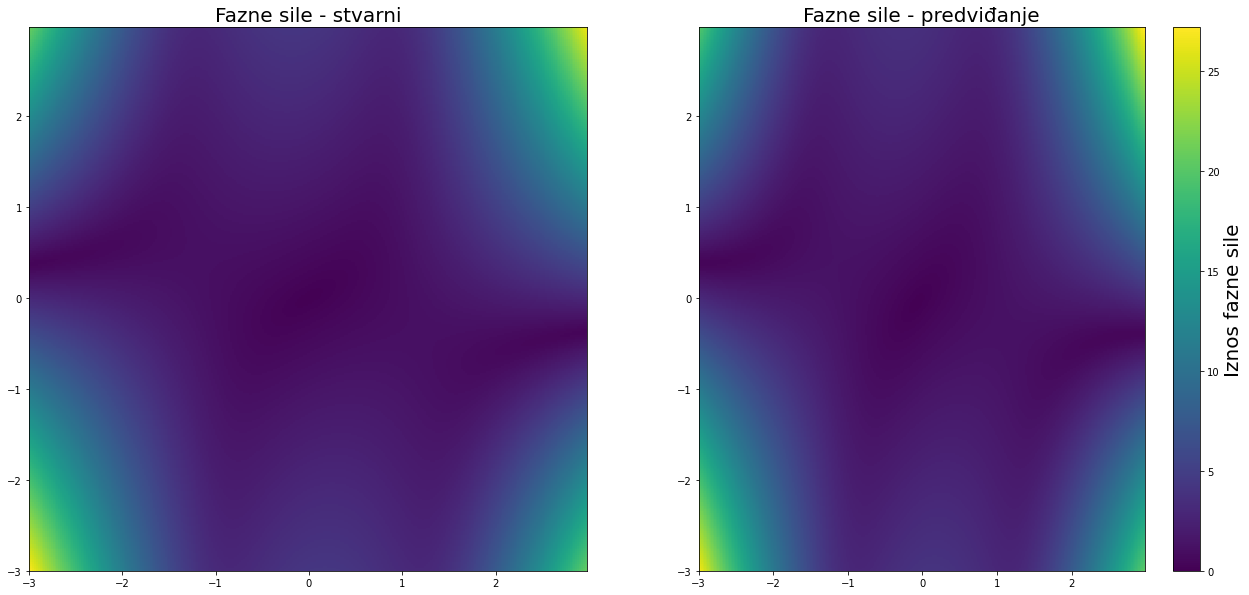

In [11]:
size_real = zeros((300,300))
size_neural = zeros((300,300))

for i in range(300):
    for j in range(300):
        size_real[j,i] = sqrt(u[j,i]**2 + v[j,i]**2)
        size_neural[j,i] = sqrt(pred[j,i,0]**2 + pred[j,i,1]**2)
        
X,Y = meshgrid(x_mesh,y_mesh)
frame,fig =plt.subplots(1,2,figsize =(22,10))
mp = fig[0].pcolor(X,Y,size_real)
fig[1].pcolor(X,Y,size_neural)
cs = frame.colorbar(mp,cmap='jet')
cs.set_label('Iznos fazne sile',size=20)
fig[0].set_title("Fazne sile - stvarni",fontsize =20)
fig[1].set_title("Fazne sile - predviđanje",fontsize =20)
frame.savefig("Iznos_faznih sila")

In [ ]:
x = 0.1
y = 0.3
X,Y = [],[]
xpred,ypred = x,y
Xpred,Ypred  = [],[]
dt = 0.001
for i in range(15_000):
    F = vector_field(x,y)
    x += F[0]*dt
    y += F[1]*dt
    FN = model(array([xpred,ypred]).reshape(1,2),training=False).numpy()
    xpred += FN[0][0]*dt
    ypred += FN[0][1]*dt
    X.append(x)
    Y.append(y)
    Xpred.append(xpred)
    Ypred.append(ypred)

    
frame,fig = plt.subplots(figsize = (10,10))    
fig.plot(X,Y,label = "Stvarna putanja")
fig.plot(Xpred,Ypred,label = "Predviđena putanja")
fig.legend(fontsize = 15)

In [612]:
#Učenje kontinuacije dinamike
# #Podatke uzima s jedne krivulje
t = arange(0,15,1e-2)
L = len(t)
Npts = 500
initial_train =[0.1,0.1]
train_traj = odeint(van_der_pol,initial_train,t)
X_train = train_traj[::2,:]
#Y_train = zeros((Npts,2))
# initial_train = [3,-3]
# train_traj = odeint(van_der_pol,initial_train,t)
# X_train = concatenate((X_train,train_traj[::2,:]))

initial_val = [0.3,0.4]
val_traj = odeint(van_der_pol,initial_val,t)
X_val = val_traj[::2,:]
#Y_val = zeros((Npts,2))



initial_test = [-0.21,0.15]
test_traj = odeint(van_der_pol,initial_test,t)
X_test = test_traj[::2,:]
#Y_test = zeros((Npts,2))

Y_train,Y_test,Y_val = [],[],[]

for i in range(len(X_train)):
#     Y_train[i,:] += vector_field(X_train[i,0],X_train[i,1])
#     Y_val[i,:] += vector_field(X_val[i,0],X_val[i,1])
#     Y_test[i,:] += vector_field(X_test[i,0],X_test[i,1])
    Y_train.append(vector_field(X_train[i,0],X_train[i,1]))

for i in range(len(X_val)):
    Y_test.append(vector_field(X_test[i,0],X_test[i,1]))
    Y_val.append(vector_field(X_val[i,0],X_val[i,1]))
    
Y_train = array(Y_train)
Y_test = array(Y_test)
Y_val = array(Y_val)


In [705]:
# #Definiranje modela2 koji predviđa trajektoriju u naprijed
act = "swish"
model2= keras.Sequential([layers.BatchNormalization(input_shape = [2]),
                        layers.Dense(8,activation = act),
                         layers.BatchNormalization(),
#                         layers.Dropout(rate = 0.05),
                        
#                         layers.Dense(10,activation=act),#'tanh'),
#                         layers.BatchNormalization(),
#                         #layers.Dropout(rate =0.2 ),
                          
#                         layers.Dense(10,activation = act),
#                         layers.BatchNormalization(),
# #                         layers.Dropout(rate = 0.2),
                       
                        layers.Dense(8,activation = act),
                        layers.BatchNormalization(),
                     
                        layers.Dense(2)])

#Optimizaciski algoritam
opt =keras.optimizers.Adam(
    learning_rate=0.002)
#mse - Mean square error - to želiš minimizirati
model2.compile(optimizer = opt,
               loss = 'mse')


early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.1, # minimium amount of change to count as an improvement
    patience=100, # how many epochs to wait before stopping
    restore_best_weights=True,
)




In [706]:
history2 = model2.fit(X_train,Y_train,
                      validation_data = (X_val,Y_val),
                      batch_size = 64,
                      epochs = 1000,
                   callbacks =[early_stopping]
)




Epoch 1/1000
12/12 [==============================] - 1s 16ms/step - loss: 1.1529 - val_loss: 1.8271
Epoch 2/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.5547 - val_loss: 1.7690
Epoch 3/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.3878 - val_loss: 1.6921
Epoch 4/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.3053 - val_loss: 1.6696
Epoch 5/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.2891 - val_loss: 1.6625
Epoch 6/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.2357 - val_loss: 1.6502
Epoch 7/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.2053 - val_loss: 1.6282
Epoch 8/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.2053 - val_loss: 1.6100
Epoch 9/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.1839 - val_loss: 1.5628
Epoch 10/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.2042 - val_loss: 1.521

12/12 [==============================] - 0s 4ms/step - loss: 0.0737 - val_loss: 0.0138
Epoch 83/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0702 - val_loss: 0.0084
Epoch 84/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0680 - val_loss: 0.0094
Epoch 85/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0903 - val_loss: 0.0093
Epoch 86/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0723 - val_loss: 0.0094
Epoch 87/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0999 - val_loss: 0.0103
Epoch 88/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0810 - val_loss: 0.0112
Epoch 89/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0987 - val_loss: 0.0094
Epoch 90/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0841 - val_loss: 0.0082
Epoch 91/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0829 - val_loss: 0.0127
Epoc

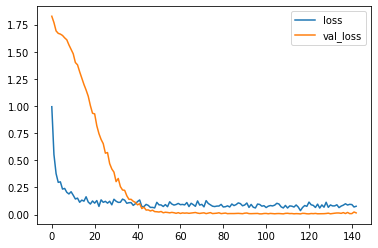

In [707]:
history_df2 = pd.DataFrame(history2.history
                        )
history_df2.loc[:,['loss','val_loss']].plot()

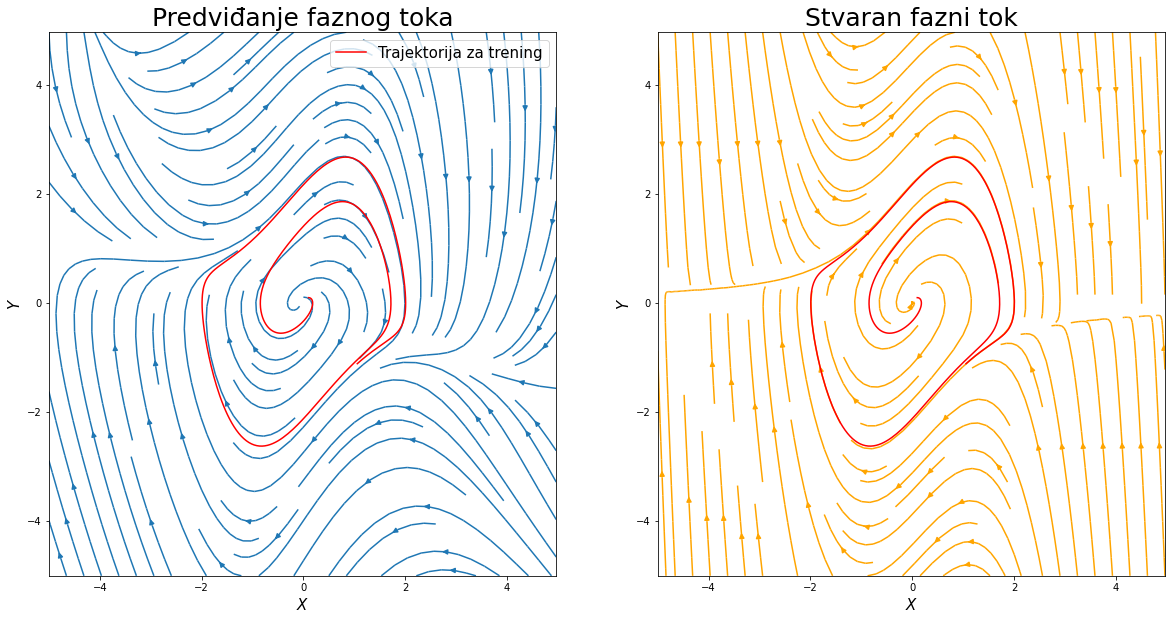

In [708]:
span = 5

x_mesh = arange(-span,span,2*span/300)
y_mesh = arange(-span,span,2*span/300)
u = zeros((len(x_mesh),len(x_mesh)))
v = zeros((len(x_mesh),len(x_mesh)))

data =[]
for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        data.append([x_mesh[j],y_mesh[i]])   
        
        
data = array(data)
pred = model2.predict(data)
pred =pred.reshape(300,300,2)


for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        u[j,i],v[j,i] = vector_field(x_mesh[i],y_mesh[j])


frame,fig = plt.subplots(1,2,figsize = (20,10))
fig[0].streamplot(x_mesh,y_mesh,pred[:,:,0],pred[:,:,1],density = 1)
fig[1].streamplot(x_mesh,y_mesh,u,v,density = 1,color ="orange")
fig[0].set_title("Predviđanje faznog toka",fontsize = 25)
fig[1].set_title("Stvaran fazni tok",fontsize = 25)
fig[0].set_xlabel(r"$X$",fontsize = 15)
fig[0].set_ylabel(r"$Y$",fontsize = 15)
fig[1].set_xlabel(r"$X$",fontsize = 15)
fig[1].set_ylabel(r"$Y$",fontsize = 15)
print()
#fig[0].plot(X,Y)
fig[0].plot(X_train[:,0],X_train[:,1],color ="red",label ="Trajektorija za trening")

fig[1].plot(X_train[:,0],X_train[:,1],color = "red")
fig[0].legend(fontsize = 15)
frame.savefig("Krivulje_usporedba")

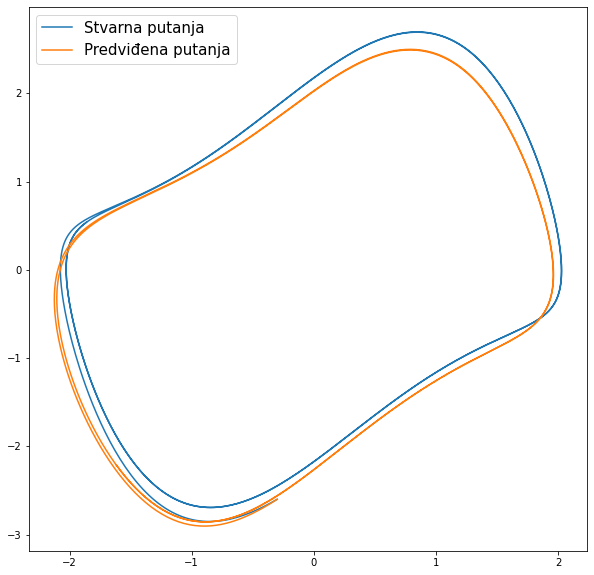

In [712]:
x = -0.3
y = -2.6
X,Y = [x],[y]
xpred = x
ypred = y
Xpred,Ypred =[x],[y]
dt = 0.01
for i in range(1500):
    diff = vector_field(x,y)
    x += diff[0]*dt
    y += diff[1]*dt
    neural = model2.predict(array([xpred,ypred]).reshape(1,2))
    xpred += neural[0][0]*dt
    ypred += neural[0][1]*dt
    Xpred.append(xpred)
    Ypred.append(ypred)
    X.append(x)
    Y.append(y)
frame,fig  = plt.subplots(figsize = (10,10)) 
fig.plot(X,Y,label = "Stvarna putanja")
fig.plot(Xpred,Ypred,label = "Predviđena putanja")
fig.legend(fontsize =15)
frame.savefig("Predviđanje_atrakt2")